In [42]:
import numpy as np
from scipy import sparse

# .. for plotting ..
import pylab as plt
# .. to generate a synthetic dataset ..
from sklearn import datasets
from tqdm import tqdm

import seaborn as sns
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from time import process_time_ns

def generate_dataset(n_samples, n_features):
    A, b = datasets.make_regression(n_samples, n_features)

    return A, b

datasets_list = []
n_features_list = [100, 500, 1000, 2000]
n_samples_list = [1000, 1000, 1000, 1000]

for i in range(len(n_features_list)):
    n_features = n_features_list[i]
    n_samples = n_samples_list[i]
    A, b = generate_dataset(n_samples, n_features)
    H = A.T @ A
    n = 10000
    eigenvalue = 0
    u = np.ones((n_features, 1))
    for i in tqdm(range(n)):
        u = H@u
        eigenvalue = np.max(u)
        u = u/eigenvalue

    L = eigenvalue

    datasets_list.append((generate_dataset(n_samples, n_features), L))

# n_features = 10000
# n_samples = 10000
# A, b = generate_dataset(n_samples, n_features)
# H = A.T @ A
# L = np.linalg.eigvals(H).max()
# print(L)
# n = 10000
# eigenvalue = 0
# u = np.ones((n_features, 1))
# for i in tqdm(range(n)):
#     u = H@u
#     eigenvalue = np.max(u)
#     u = u/eigenvalue

# L = eigenvalue
# print(L)

100%|██████████| 10000/10000 [00:24<00:00, 401.57it/s]


In [43]:
def predef_decreasing_seq(t):
    '''
        Compute predefined decreasing sequence for stepsize.

        t(int) - timestep.
    '''
    return 2.0 / (t + 2.0)

def exact_line_search(opt_line_search, *args):
    '''
        Compute exact line-search sequence for stepsize.

        gamma_opt - solution for argmin_{c \in C} (grad f, c);
        qt(ndarray) - A(st - xt).
    '''

    gamma_t = opt_line_search(*args)

    return min(gamma_t, 1.)

def DR_stepsize(dt, gt, L):
    '''
        Demyanov-Rubinov sequence for stepsize.
        dt(sparse vector) - st - xt;
        gt(float) - <-grad f, dt>, stopping criterion(how our direction correlates with gradient);
        L - Lipschitz constant of gradient f.
    '''

    return min((1 / L) * gt / dt.multiply(dt).sum(), 1.)

def backtracking_linesearch(xt, dt, gt, Mt, eta, tau, f, Q, *args):
    '''
        eta <= 1, tau > 1.
    '''

    Mt = eta * Mt
    gamma_t = DR_stepsize(dt, gt, Mt)
    f_xt = f(*args, xt)
    while f(*args, xt + gamma_t * dt)  > Q(f_xt, gt, dt, gamma_t, Mt):
        Mt = tau * Mt
        gamma_t = DR_stepsize(dt, gt, Mt)

    return gamma_t, Mt

Density of solution: 2.0%
Density of solution: 2.0%
Density of solution: 2.0%
Density of solution: 2.0%


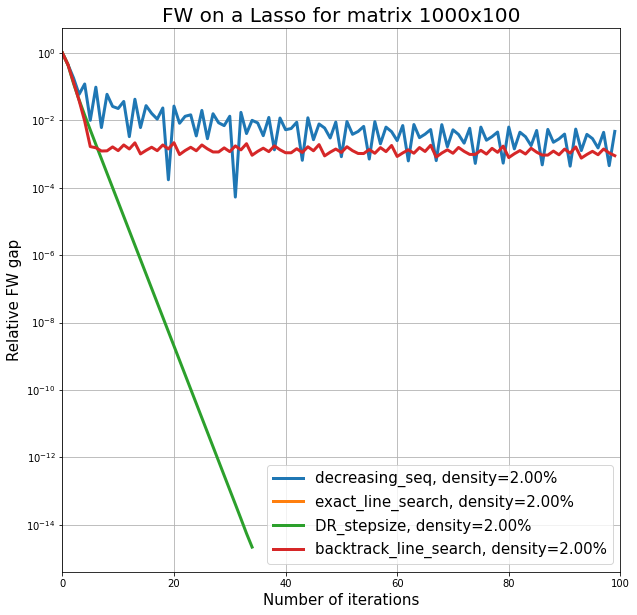

Density of solution: 1.2%
Density of solution: 1.2%
Density of solution: 1.2%
Density of solution: 1.2%


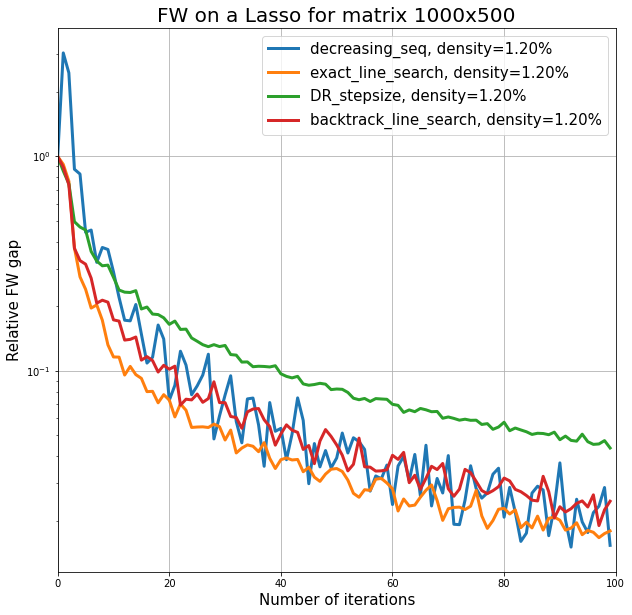

Density of solution: 0.8999999999999999%
Density of solution: 1.0%
Density of solution: 0.8999999999999999%
Density of solution: 1.0%


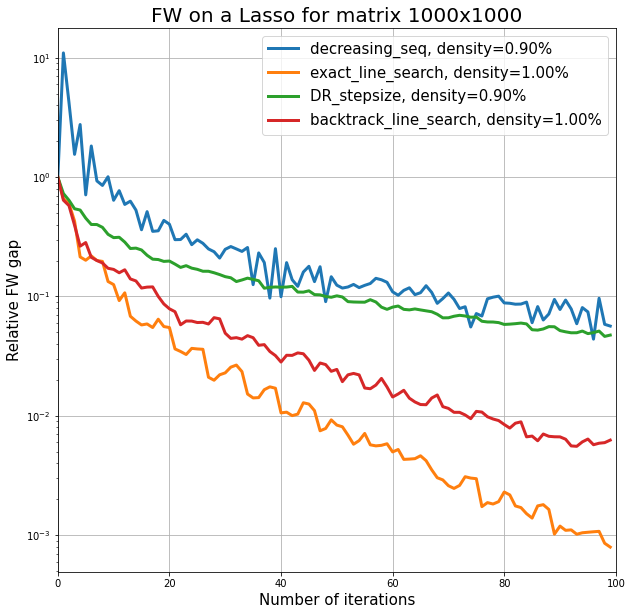

Density of solution: 0.5%
Density of solution: 0.5%
Density of solution: 0.5%
Density of solution: 0.5%


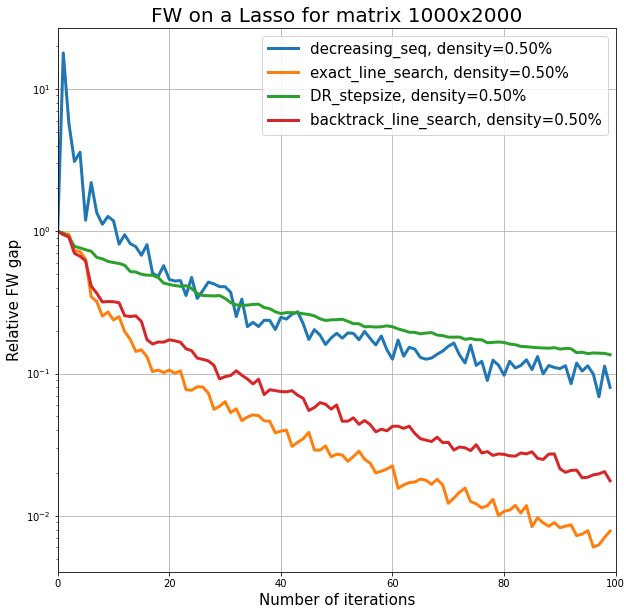

In [46]:
def lasso_gamma_opt(A, b, xt, qt):
    # r = b - A.dot(xt)
    r = b - xt.T.dot(A.T).ravel() #If A.dot(xt) then xt is seen as np.array, but it is a sparse matrix
    numerator = (qt * r).sum()
    denominator = (qt**2).sum()

    return numerator / denominator

def f(A, b, x):
    Axb = x.T.dot(A.T).ravel() - b
    return 0.5 * (Axb**2).sum()

def Q(f_xt, gt, dt, gamma_t, Mt):
    return f_xt - gamma_t * gt + 0.5 * gamma_t**2 * Mt * dt.multiply(dt).sum()

def FW(alpha, A, b, max_iter=100, tol=1e-8, callback=None, scheduler=None):
    # .. initial estimate, could be any feasible point ..
    x_t = sparse.dok_matrix((n_features, 1))

    # .. some quantities can be precomputed ..
    Atb = A.T.dot(b)

    args = scheduler["args"]
    Mt = None

    for it in range(max_iter):
        # .. compute gradient. Slightly more involved than usual because ..
        # .. of the use of sparse matrices ..
        Ax = x_t.T.dot(A.T).ravel()
        grad = (A.T.dot(Ax) - Atb)

        # .. the LMO results in a vector that is zero everywhere except for ..
        # .. a single index. Of this vector we only store its index and magnitude ..
        idx_oracle = np.argmax(np.abs(grad))
        mag_oracle = alpha * np.sign(-grad[idx_oracle])
        d_t = -x_t.copy()
        d_t[idx_oracle] += mag_oracle

        if it == 0 and scheduler["name"] == "backtrack_line_search":
            eps = args["eps"]
            numerator = eps * A.T.dot(d_t.T.dot(A.T).ravel())
            denominator = eps * np.sqrt(d_t.multiply(d_t).sum())
            Mt = np.linalg.norm(numerator) / denominator

        g_t = - d_t.T.dot(grad).ravel()[0]

        if g_t <= tol:
            break
        q_t = A[:, idx_oracle] * mag_oracle - Ax
        # step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
        step_size = 0.0
        if scheduler["name"] == "decreasing_seq":
            step_size = predef_decreasing_seq(it)
        elif scheduler["name"] == "exact_line_search":
            step_size = exact_line_search(args["opt_line_search"], A, b, x_t, q_t)
        elif scheduler["name"] == "DR_stepsize":
            step_size = DR_stepsize(d_t, g_t, args["L"])
        elif scheduler["name"] == "backtrack_line_search":
            step_size, Mt = backtracking_linesearch(x_t, d_t, g_t, Mt, args["eta"], args["tau"],
                                                    args["f"], args["Q"], A, b)

        x_t += step_size * d_t
        if callback is not None:
            callback(g_t)
    return x_t

def run(alpha, A, b, scheduler):
    '''
        alpha - ...
        scheduler(dict) - name of the stepsize decreasing method;
        
        scheduler has fields:
        "name"(str): one of ["decreasing_seq", "exact_line_search", "DR_stepsize", "backtrack_line_search"]
        "args"(dict): if "exact_line_search" then you should pass linreg_gamma_opt func which solves linesearch
                if "backtrack_line_search" then you should pass eta and tau
                if "DR_stepsize" then you should pass L(Lipschitz constant of gradient)
                in other cases it should be None
    '''
    trace = []

    def callback(g_t):
        trace.append(g_t)

    sol = FW(alpha, A, b, callback=callback, scheduler=scheduler)

    density = np.mean(sol.toarray().ravel() != 0)

    plt.plot(trace / trace[0], lw=3, label=scheduler["name"] + f", density={density * 100:.2f}%")
    print('Density of solution: %s%%' % (density * 100))

iter = 0
for (A, b), L in datasets_list:
    decr_seq_scheduler = {"name": "decreasing_seq", "args": None}
    ExactLS_scheduler = {"name": "exact_line_search", "args": {"opt_line_search": lasso_gamma_opt}}
    DR_scheduler = {"name": "DR_stepsize", "args": {"L": L}}
    BCLS_scheduler = {"name": "backtrack_line_search", "args": {"eps": 1e-3,
                                                        "f": f,
                                                        "Q": Q,
                                                        "tau": 2.0,
                                                        "eta": 0.9}}

    exps = [decr_seq_scheduler, ExactLS_scheduler, DR_scheduler, BCLS_scheduler]

    n_samples = A.shape[0]
    n_features = A.shape[1]

    iter += 1

    plt.figure(figsize=(10, 10))

    for exp in exps:
        run(.5 * n_features, A, b, scheduler=exp)

    plt.yscale('log')
    plt.xlabel('Number of iterations', fontsize=15)
    plt.ylabel('Relative FW gap', fontsize=15)
    plt.title(f'FW on a Lasso for matrix {n_samples}x{n_features}', fontsize=20)
    plt.legend(fontsize=15)
    plt.xlim((0, 100))
    plt.grid(True)
    plt.savefig(f"fig_{iter}.png")
    plt.show()